In [32]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.special import loggamma
from scipy.stats import wasserstein_distance
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path

from earthquake import EarthquakeCatalog
from repeater import RepeaterCatalog, RepeaterSequences
from research_util import add_lettering

data_directory = Path('data/earthquake_catalogs/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### To do:
- Remove events that are clearly in aftershocks sequences
- Bug: sequence with no aftershocks even after the min event threshold is specified.
- Make sure that the repeaters -> sequences surrogates are representative (same number etc) 
- 

In [33]:
earquake_metadata = {
    "starttime": '1990-01-01',
    "endtime": '2024-01-01',
    "latitude_range": [-90,90],
    "longitude_range": [-180,180],
    "minimum_magnitude": 1, 
} 

earthquakes = EarthquakeCatalog(
    filename=data_directory/'global_ALL.csv',
    kwargs=earquake_metadata,
) # expect warnings about loading existing catalog and Nan values

/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/earthquake.py:176: UserWarning: Using existing data/earthquake_catalogs/global_ALL.csv
  warnings.warn(f"Using existing {filename}")
/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/earthquake.py:182: UserWarning: 27913 NaN values found in catalog. Removing rows with NaN values.
  warnings.warn(


In [34]:
surrogate_config = dict(
    max_distance_km = 800, # selected to preserve some of the same structure with Mc and similar tectonic setting        
    max_magnitude_delta = 0.1, # comparable to (event_pairs.catalog.Mag - event_pairs.catalog.Mag_2).abs().mean()  
    min_time_delta_days = 365, # avoid the events being related to eachother
    min_prior_time_delta = 60, # avoid mainshocks occuring before the event
)

event_pairs = RepeaterCatalog(data_directory/"jgrb540690-sup-0002-2019jb018652-ts01.txt")
dummy_event_pairs = event_pairs.create_surrogate_catalog(other_catalog=earthquakes, **surrogate_config)

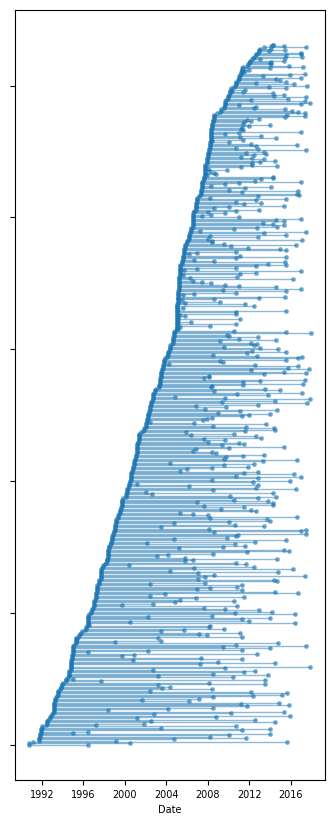

In [35]:
event_pairs.plot_pairs()

In [36]:
sequence_config = dict(
    sequence_duration_days = 30,
    sequence_start_dt_days = 0,
    minimum_number_of_events = 3,      # ensures that sequences comparisons are meaningful
    radius_for_mc_determination = 100, # km
    radius_for_sequence = 30,          # km
    apply_same_completness = True,     # applies the higher completeness among the two sequences
)

# d1 = DoubletSequences(event_pairs,earthquakes, **sequence_config)
# d2 = DoubletSequences(dummy_event_pairs,earthquakes, **sequence_config)
dummy_sequences = RepeaterSequences(dummy_event_pairs,earthquakes, **sequence_config).sequences
sequences = RepeaterSequences(event_pairs,earthquakes, **sequence_config).sequences

In [37]:
def counting_measure_distance(t1,t2,T):
    
    n1, n2 = len(t1), len(t2)
    sorted_indices = np.argsort([n1, n2])
    
    t = [t1, t2][sorted_indices[0]]
    u = [t1, t2][sorted_indices[1]]
    
    return (
        np.sum(np.abs(t-u[:len(t)])) +
        np.sum(T-u[len(t):])
    )/max([n1,n2]) # appendix E.2 of Shchur et al., 2020

In [38]:
def calculate_spread(time_array, pair, method='counting measure distance'):
    seq1 = pair["catalog_1"]
    seq2 = pair["catalog_2"]
    
    t1 = ((seq1.catalog.time - seq1.start_time)/np.timedelta64(1,'D')).values
    t2 = ((seq2.catalog.time - seq2.start_time)/np.timedelta64(1,'D')).values
    
    N1 = np.array([np.sum(t1 < t) for t in time_array])
    N2 = np.array([np.sum(t2 < t) for t in time_array])

    if method == 'difference':
        N2byN1 = np.abs(N1-N2)
    elif method == 'absolute relative difference':
        N2byN1 = np.abs(N1-N2)/N1
    elif method == 'relative difference':
        N2byN1 = (N1-N2)/N1
    elif method == 'poisson':
        N2byN1 = (
            (N2+N1+1) * -np.log(2) 
            + loggamma(N2+N1) 
            - loggamma(N2) 
            - loggamma(N2)
        ) # avoids overflow
    elif method == 'counting measure distance':
        N2byN1 = [counting_measure_distance(t1[t1<Ti], t2[t2<Ti], Ti) for Ti in time_array]
    return N2byN1

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_77323/867797953.py:34: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  seq1.catalog.time[:count_for_comparison],
/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_77323/867797953.py:35: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  seq2.catalog.time[:count_for_comparison]
/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_77323/867797953.py:47: FutureWarning: The behavior of `series[i:j]` with an integer-dt

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

/Users/kdascher/miniforge3/envs/eq_stats/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


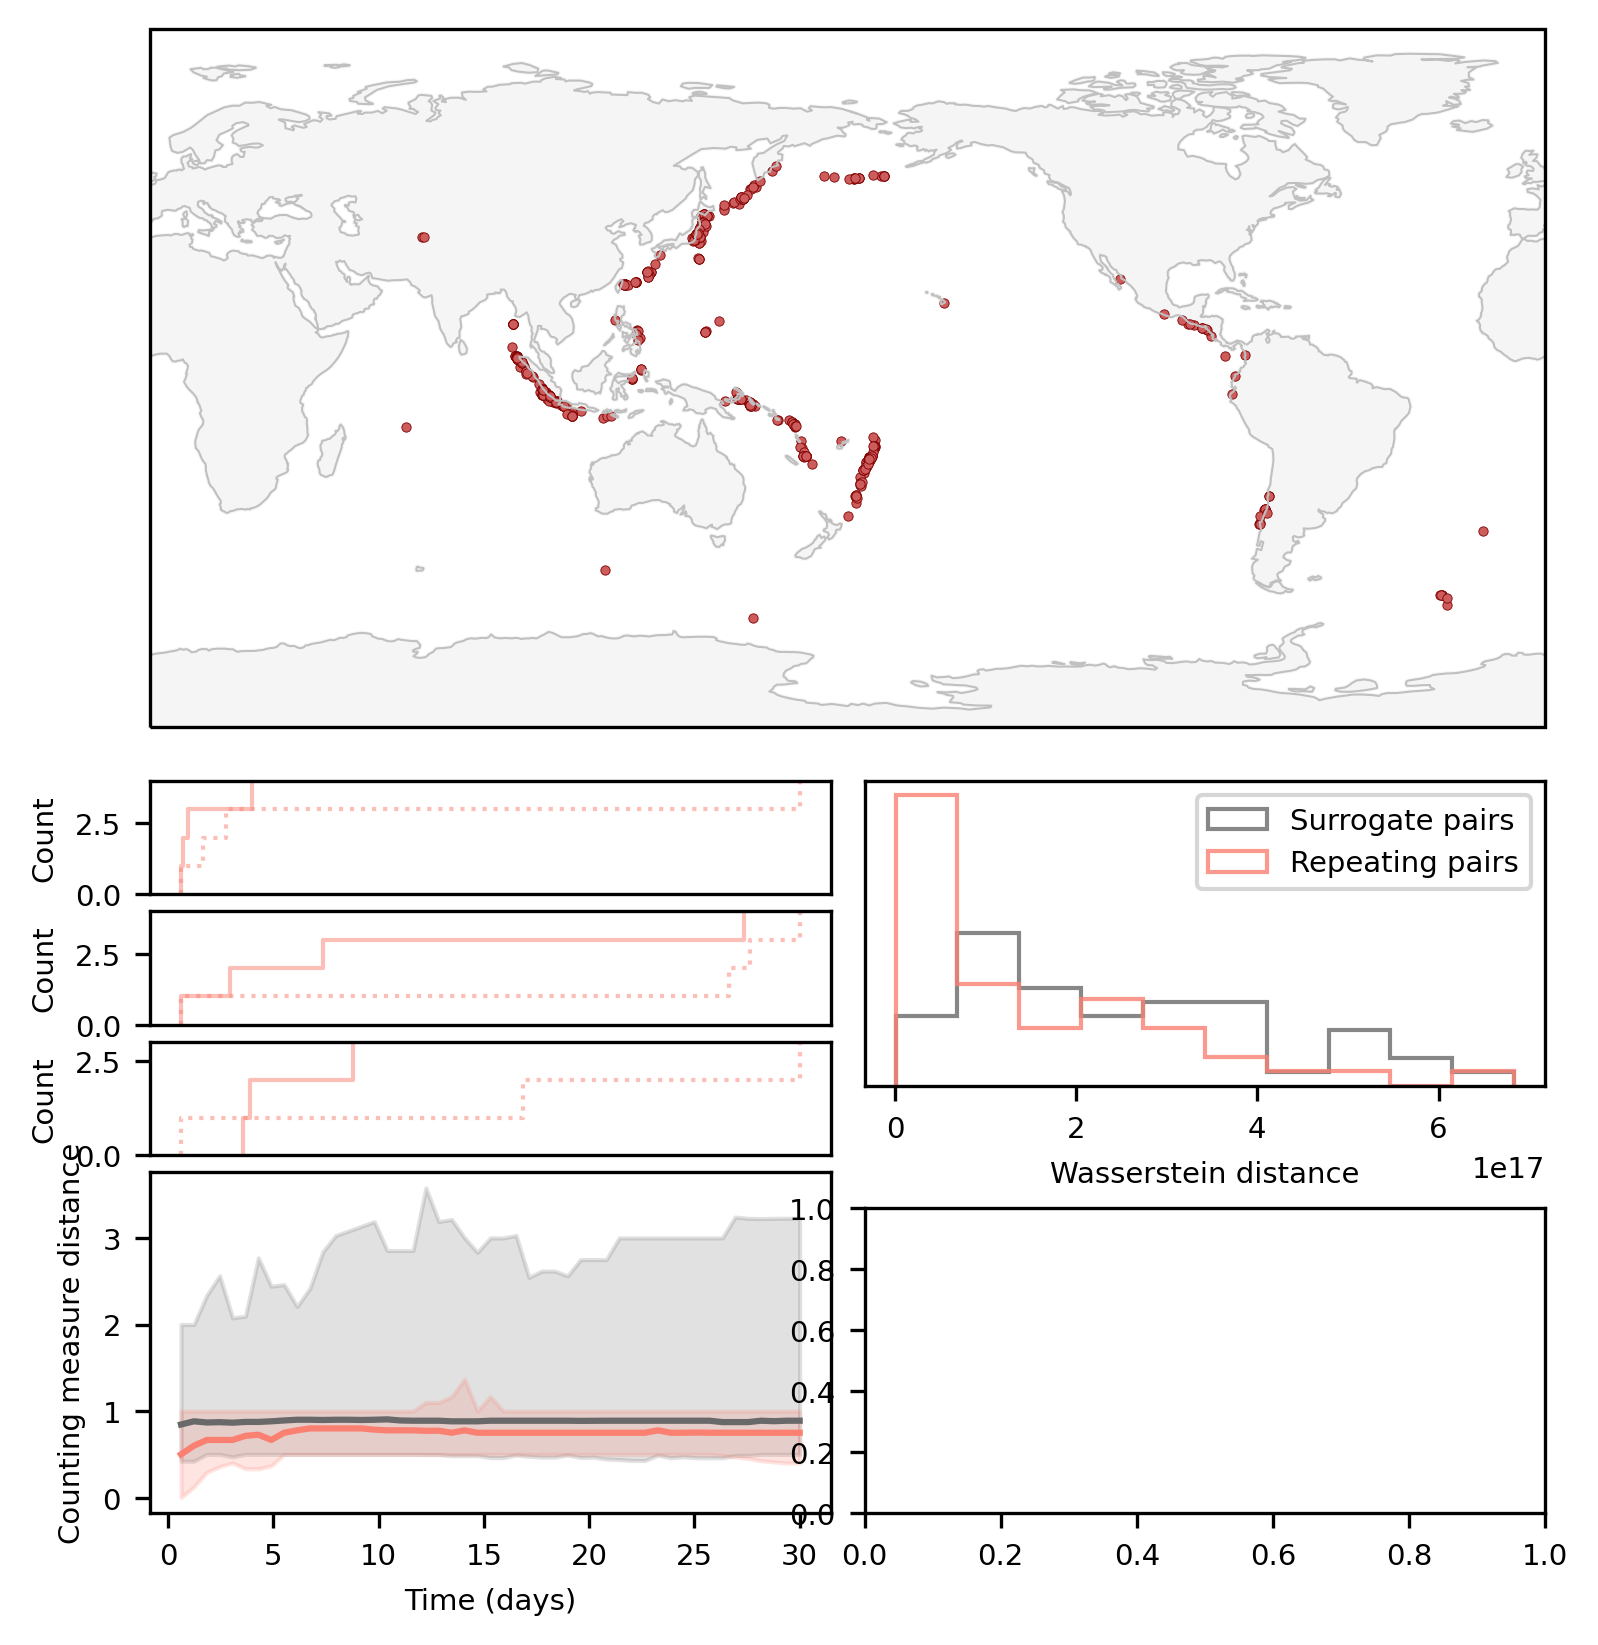

In [61]:
plt.rcParams.update({'font.size': 7})
quantile_range = [0.25,0.75]
nw_min = 5

data_color = "salmon"
dummy_color = "dimgray"

fig = plt.figure(figsize=(6,6.5), dpi=300)
gs = fig.add_gridspec(2,2,hspace=0.05,wspace=0.05)

# Top panel: the map
ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=180))

event_pairs.plot_map(scatter_kwarg=dict(s=5, c='indianred',lw=0.2,edgecolor='maroon'),ax=ax)
ax.set(
    extent=[-180,180,-90,90],
)

gs_left = gs[1,0].subgridspec(4,1,hspace=0.1,height_ratios=[1,1,1,3])
gs_right = gs[1,1].subgridspec(2,1,hspace=0.4)

# middle right panel: wassersein diffenrence
ax = fig.add_subplot(gs_right[0,0])
w_difference = []
for pair in sequences:
    seq1 = pair["catalog_1"]
    seq2 = pair["catalog_2"]
    if min([len(seq1),len(seq2)]) < nw_min:
        w_difference.append(np.nan)
    else:
        count_for_comparison = min([len(seq1),len(seq2)])
        w_difference.append(
            wasserstein_distance(
                seq1.catalog.time[:count_for_comparison], 
                seq2.catalog.time[:count_for_comparison]
            )
        )

dummy_w_difference = []
for pair in dummy_sequences:
    seq1 = pair["catalog_1"]
    seq2 = pair["catalog_2"]
    if min([len(seq1),len(seq2)]) < nw_min:
        dummy_w_difference.append(np.nan)
    else:
        count_for_comparison = min([len(seq1),len(seq2)])
        dummy_w_difference.append(wasserstein_distance(seq1.catalog.time[:count_for_comparison], seq2.catalog.time[:count_for_comparison]))                   

hist_kwargs = dict(
    alpha=0.8,
    density=True,
    color=[data_color,dummy_color],
    label=['Repeating pairs','Surrogate pairs'],
    histtype='step',
)

ax.hist(
    [w_difference, dummy_w_difference], 
    **hist_kwargs,
)
ax.legend()

ax.set(
    xlabel="Wasserstein distance",
    yticks=[],
)

# Bottom left panel: comparison of spread over time: 
ax = fig.add_subplot(gs_left[-1,0])
spread = []
time_array = np.linspace(0,30,50)
for pair in sequences:
    N2byN1 = calculate_spread(time_array, pair, method="absolute relative difference")
    spread.append(N2byN1)
spread = np.array(spread) 
dummy_spread = np.array([calculate_spread(time_array, pair, method="absolute relative difference") for pair in dummy_sequences])

dummy_line = ax.plot(time_array, np.median(dummy_spread, axis=0), c=dummy_color, label='Surrogate pairs')
dummy_fill = ax.fill_between(time_array, *np.quantile(dummy_spread, quantile_range, axis=0), alpha=0.2, color=dummy_color)

data_line = ax.plot(time_array, np.median(spread, axis=0), c=data_color, label='Repeating pairs')
data_fill = ax.fill_between(time_array, *np.quantile(spread, quantile_range, axis=0), alpha=0.2, color=data_color)
ax.set(ylabel="Counting measure distance", xlabel="Time (days)")

# middle left panel: compison of sequences
number_of_examples = 3
for ax, pair in zip(
    [fig.add_subplot(gs_left[i,0]) for i in range(number_of_examples)],
    [sequences[i] for i in np.argsort(spread[:,-1])[:number_of_examples]]):
    
    seq1 = pair["catalog_1"]
    seq2 = pair["catalog_2"]
    
    N0 = len(seq1)
    for ls, seq in zip([':','-'],[seq1,seq2]):
        sns.ecdfplot(
            ((seq.catalog.time - seq.start_time)/np.timedelta64(1,'D')).values, 
            stat='count',
            color=data_color,
            alpha=0.5,
            ax=ax,
            ls=ls,
            lw=1,
        )
    ax.set(xticks=[],xticklabels=[]) 

# bottom right panel: count measure histogram comparison
ax = fig.add_subplot(gs_right[1,0])
hist_kwargs = dict(
    alpha=0.8,
    density=True,
     color=[data_color,dummy_color],
    label=['Repeating pairs','Surrogate pairs'],
    histtype='step',
)

final_spread = spread[:,-1][~np.isinf(spread[:,-1]) and ~np.isnan(spread[:,-1])]
final_dummy_spread = dummy_spread[:,-1][~np.isinf(dummy_spread[:,-1]) and ~np.isnan(spread[:,-1])]

ax.hist([spread[:,-1],dummy_spread[:,-1]], **hist_kwargs)
ax.set(xlabel="Counting measure \n distance", yticks=[])


add_lettering(fig.get_axes(), position=[0.008, 0.800])

In [59]:
spread

array([       nan, 0.5       , 1.5       , ..., 0.76119403, 0.76119403,
       0.76119403])

In [64]:
len(event_pairs)

532

In [62]:
len(sequences)


107

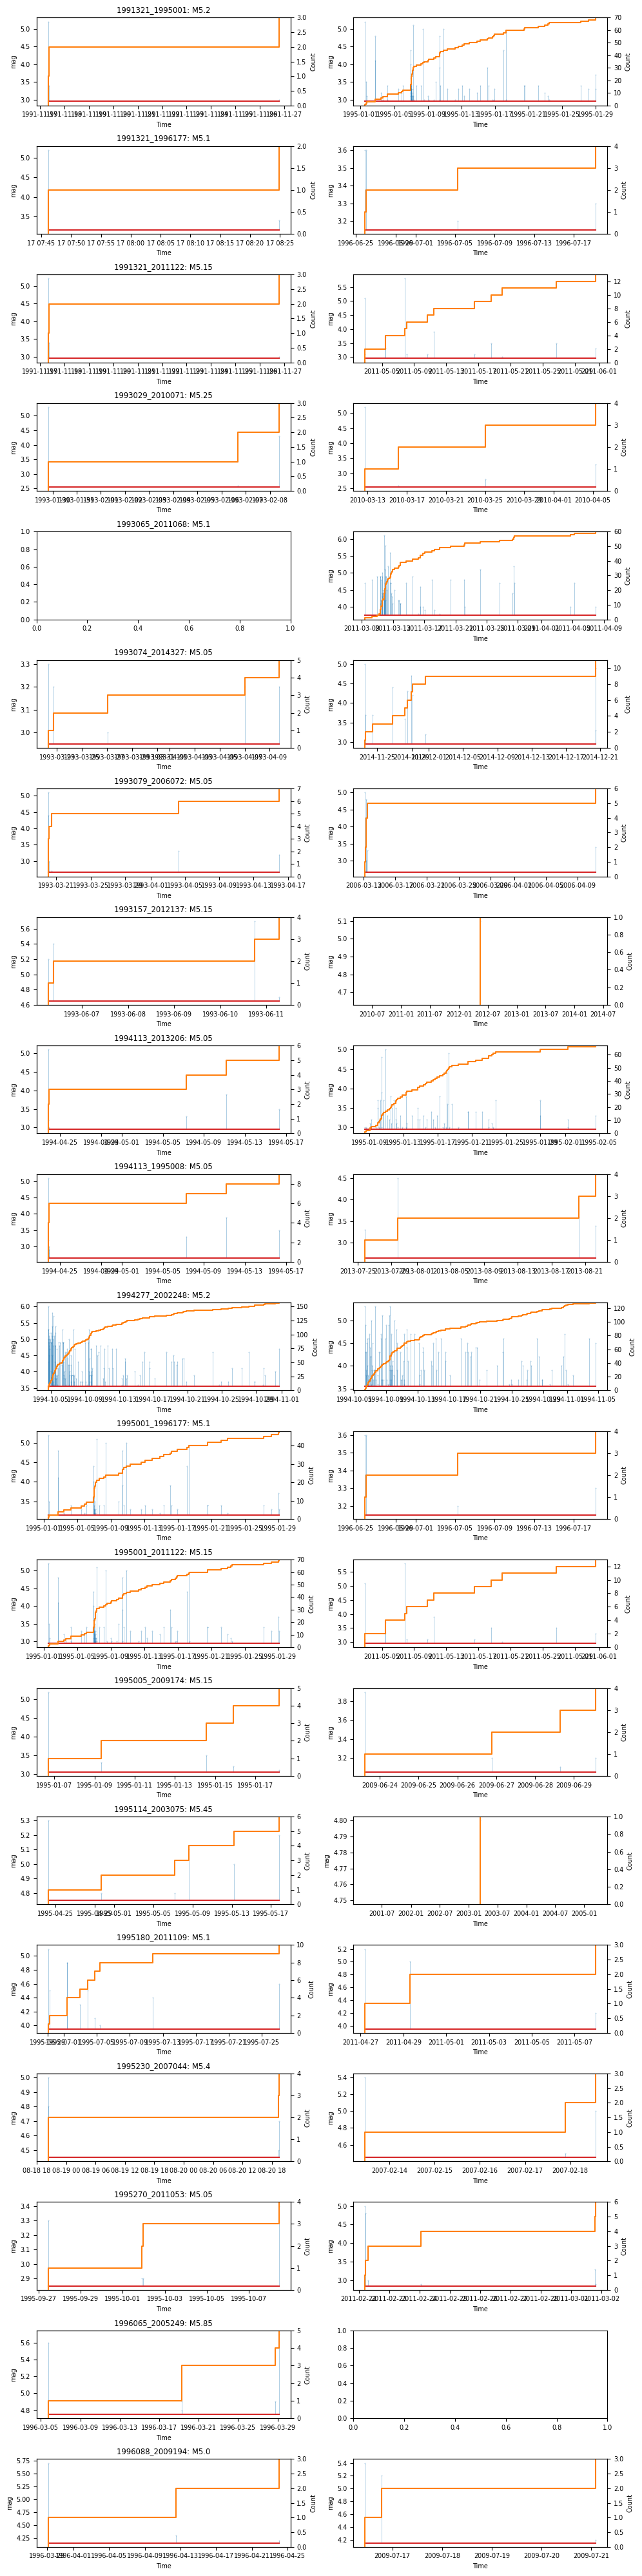

In [56]:
number_of_examples = 20
fig, AX = plt.subplots(number_of_examples,2,figsize=(10,number_of_examples*2))

for i, pair in enumerate(sequences[:number_of_examples]):
    if len(pair["catalog_1"]) > 0:
        pair["catalog_1"].plot_time_series(ax=AX[i,0])
    if len(pair["catalog_2"]) > 0:
        pair["catalog_2"].plot_time_series(ax=AX[i,1])
    AX[i,0].set(
        title= pair["Doublet_ID"] +': ' + f"M{(pair['Mag'] + pair['Mag_2'])/2}",
    )

plt.tight_layout()